# Exploring sea ice heights with ICESat-2 (ATL07)

Information obtained primarily from the ATL07/10 Algorithm Theoretical Basis Document (ATBD, Kwok et al., 2019)     and the NSIDC product description page: https://nsidc.org/data/atl07.   

Notebook author: Alek Petty, relying extensively on above product manuals. 
Description: Notebook describing the ICESat-2 ATL07 product.   
Input requirements: Demo ATL07 data file   
Date: June 2019
More info: See the ATL07/ATL10 Algorithm Theoretical Basis Document (ATBD): https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL07_ATL10_ATBD_r001.pdf   


## Notebook objectives
* General understanding of what's included in a typical ATL07 file.
* Plotting and basic analysis of ATL07 data.
* Potentially some info on reading in and analyzing a large quantity of ATL07 data!


# Notebook instructions
1. Follow along with the notebook tutorial. 
2. Play around changing options and re-running the relevant notebook cells. 

Here I use the hdf5 file from: https://nsidc.org/data/atl07   
For the demo below I'm using the file: 'ATL07-01_20181115003141_07240101_001_01.h5'
If using this using the ICESAT-2 Pangeo instance, you can download the file using...


### Notes      
* Check out the known issues document:https://nsidc.org/sites/nsidc.org/files/technical-references/ATL0710-KnownIssues.pdf



In [21]:
#Magic function to enable interactive plotting in Jupyter notebook
#Allows you to zoom/pan within plots after generating
#Normally, this would be %matplotlib notebook, but since we're using Juptyerlab, we need a different widget
#%matplotlib notebook
%matplotlib inline

In [22]:
#Import necesary modules
#Use shorter names (np, pd, plt) instead of full (numpy, pandas, matplotlib.pylot) for convenience
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import convert_GPS_time as cGPS
import seaborn as sns
import pandas as pd
import h5py  

In [23]:
# Use seasborn for nicer looking inline plots
sns.set(context='notebook', style='darkgrid')
#st = axes_style("whitegrid")

file_path = './Data/'
ATL07_filename = 'ATL07-01_20181115003141_07240101_001_01.h5'
ATL07_file_path = file_path + ATL07_filename
beamStr='gt1r'

In [24]:
# add an option if you want to spit out data as an array or a pandas dataframe.

def getATL07data(fileT, numpy=0, beam='gt1l', maxElev=1e6):
    # Add in a proper description of the function here
    
    
    # Open the file
    ATL07 = h5py.File(fileT, 'r')
    
    lons=ATL07[beam+'/sea_ice_segments/longitude'][:]
    lats=ATL07[beam+'/sea_ice_segments/latitude'][:]
    
    # Along track distance from equator i think.
    along_track_distance=ATL07[beam+'/sea_ice_segments/seg_dist_x'][:] 
    #  Nathan says it's the number of seconds since the GPS epoch on midnight Jan. 6, 1980 
    delta_time=ATL07[beam+'/sea_ice_segments/delta_time'][:] 
    # #Add this value to delta time parameters to compute full gps_seconds
    atlas_epoch=ATL07['/ancillary_data/atlas_sdp_gps_epoch'][:] 

    # Conversion of delta_time to a calendar date
    temp = cGPS.convert_GPS_time(atlas_epoch[0] + delta_time, OFFSET=0.0)

    year = temp['year'][:].astype('int')
    month = temp['month'][:].astype('int')
    day = temp['day'][:].astype('int')
    hour = temp['hour'][:].astype('int')
    minute = temp['minute'][:].astype('int')
    second = temp['second'][:].astype('int')


    # Primary variables of interest
    
    # Beam segment height
    elev=ATL07[beam+'/sea_ice_segments/heights/height_segment_height'][:]
    # Flag for potential leads, 0=sea ice, 1 = sea surface
    ssh_flag=ATL07[beam+'/sea_ice_segments/heights/height_segment_ssh_flag'][:] 
    
    #Quality metrics for each segment include confidence level in the surface height estimate, which is based on the number of photons, the background noise rate, and the error measure provided by the surface-finding algorithm.
    # Height quality flag, 1 for good fit, 0 for bad
    quality=ATL07[beam+'/sea_ice_segments/heights/height_segment_quality'][:] 
    
    elev_rms = ATL07[beam+'/sea_ice_segments/heights/height_segment_rms'][:] #RMS difference between modeled and observed photon height distribution
    seg_length = ATL07[beam+'/sea_ice_segments/heights/height_segment_length_seg'][:] # Along track length of segment
    height_confidence = ATL07[beam+'/sea_ice_segments/heights/height_segment_confidence'][:] # Height segment confidence flag
    reflectance = ATL07[beam+'/sea_ice_segments/heights/height_segment_asr_calc'][:] # Apparent surface reflectance
    ssh_flag = ATL07[beam+'/sea_ice_segments/heights/height_segment_ssh_flag'][:] # Flag for potential leads, 0=sea ice, 1 = sea surface
    seg_type = ATL07[beam+'/sea_ice_segments/heights/height_segment_type'][:] # 0 = Cloud covered
    gauss_width = ATL07[beam+'/sea_ice_segments/heights/height_segment_w_gaussian'][:] # Width of Gaussian fit

    
    # Geophysical corrections
    # NOTE: All of these corrections except ocean tides, DAC, and geoid undulations are applied to the ATL03 photon heights.
    
    # AVISO dynamic Atmospheric Correction (DAC) including inverted barometer (IB) effect (±5cm)
    dac = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_dac'][:] 
    # Solid Earth Tides (±40 cm, max)
    earth = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_earth'][:]
    # Geoid (-105 to +90 m, max)
    geoid = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_geoid'][:] 
    # Local displacement due to Ocean Loading (-6 to 0 cm)
    loadTide = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_load'][:] 
    # Ocean Tides including diurnal and semi-diurnal (harmonic analysis), 
    # and longer period tides (dynamic and self-consistent equilibrium) (±5 m)
    oceanTide = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_ocean'][:]
    # Deformation due to centrifugal effect from small variations in polar motion 
    # (Solid Earth Pole Tide) (±1.5 cm, the ocean pole tide ±2mm amplitude is considered negligible)
    poleTide = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_pole'][:] 
    # Mean sea surface (±2 m)
    # Taken from ICESat and CryoSat-2, see Kwok and Morison [2015])
    mss = ATL07[beam+'/sea_ice_segments/geophysical/height_segment_mss'][:]
    
    ATL07.close()
    
    
    if (numpy==1):
        # list the variables you want to output here..
        return along_track_dist, elev
    
    else:
        dF = pd.DataFrame({'elev':elev, 'lons':lons, 'lats':lats, 'ssh_flag':ssh_flag, 
                       'quality_flag':quality, 'delta_time':delta_time,'along_track_distance':along_track_distance, 'year':year, 'month':month, 'day':day, 'hour':hour, 'second':second},
                         columns=['elev','lons','lats', 'ssh_flag', 'quality_flag', 'delta_time', 'along_track_distance','year', 'month', 'day', 'hour', 'second'])
        
        # Filter out high elevation values 
        dF = dF[(dF['elev']<maxElev)]
        # Reset row indexing
        dF=dF.reset_index(drop=True)
        return dF


In [25]:
# Get data using numpy
#along_track_dist, elev=getATL07data(ATL07_file_path, numpy=1, beam=beamStr)
#good = np.where((elev < 100) )	#& (quality_1l == 1)
#along_track_dist=along_track_dist[good]
#elev=elev[good]
#plt.figure(figsize=(10, 5))
#plt.plot((along_track_dist-along_track_dist[0])/1000., elev)
#plt.xlabel('Along track distance (km)')
#plt.ylabel('Elevation (m)')
#plt.show()

# Get data using Pandas
dF07=getATL07data(ATL07_file_path, numpy=0, beam=beamStr)
dF07.head(10)


,elev,lons,lats,ssh_flag,quality_flag,delta_time,along_track_distance,year,month,day,hour,second
0,0.443309,-164.275288,59.864463,0,1,2.747804e+07,6.671127e+06,2018,11,15,0,18
1,0.439604,-164.275288,59.864463,0,1,2.747804e+07,6.671127e+06,2018,11,15,0,18
2,0.469707,-164.275327,59.864671,0,1,2.747804e+07,6.671150e+06,2018,11,15,0,18
3,0.422271,-164.275374,59.864914,0,1,2.747804e+07,6.671177e+06,2018,11,15,0,18
4,0.392907,-164.275425,59.865173,1,1,2.747804e+07,6.671207e+06,2018,11,15,0,18
5,0.463985,-164.275467,59.865382,0,1,2.747804e+07,6.671230e+06,2018,11,15,0,18
6,0.459417,-164.275525,59.865664,0,1,2.747804e+07,6.671262e+06,2018,11,15,0,18
7,0.406700,-164.275581,59.865928,1,1,2.747804e+07,6.671291e+06,2018,11,15,0,18
8,0.423204,-164.275631,59.866162,0,1,2.747804e+07,6.671317e+06,2018,11,15,0,18
9,0.486481,-164.275704,59.866502,0,1,2.747804e+07,6.671357e+06,2018,11,15,0,18


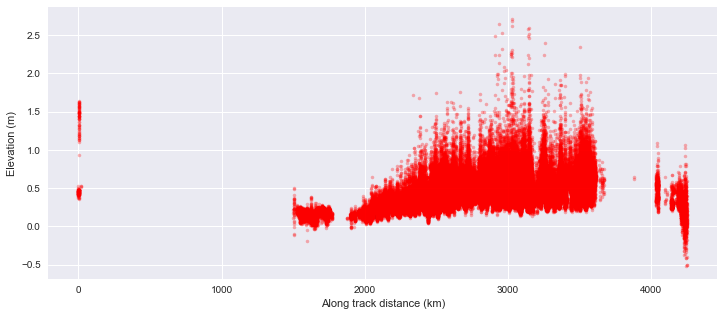

In [26]:
plt.figure(figsize=(12, 5))
plt.plot((dF07.along_track_distance-dF07.along_track_distance[0])/1000., dF07.elev, color='r', marker='.', linestyle='None', alpha=0.3)
plt.xlabel('Along track distance (km)')
plt.ylabel('Elevation (m)')
plt.show()


In [27]:
# Do a groupby of the above data based on the ssh_flag. 
# Colour code the plot using the various calssifications. 
# e.g. 
dFstype=dF07.groupby('ssh_flag')
dFstype['elev'].agg(['mean', 'std', 'median', 'mad'])

,mean,std,median,mad
ssh_flag,,,,
0,0.398336,0.188262,0.36228,0.142645
1,0.146795,0.073265,0.12388,0.060434


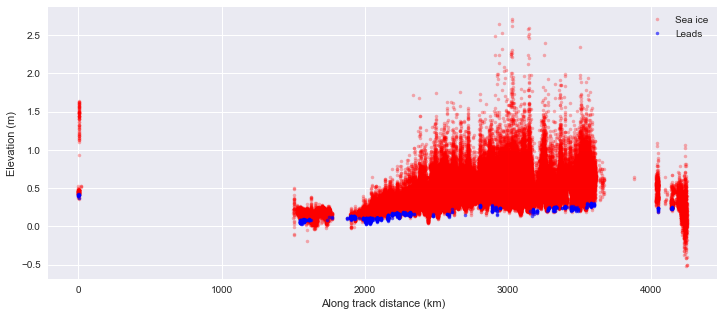

In [28]:
dFstypeIce=dFstype.get_group(0)
dFstypeLeads=dFstype.get_group(1)
plt.figure(figsize=(12, 5))
plt.plot((dFstypeIce.along_track_distance-dF07.along_track_distance[0])/1000., dFstypeIce.elev, color='r', marker='.', linestyle='None', label='Sea ice', alpha=0.3)
plt.plot((dFstypeLeads.along_track_distance-dF07.along_track_distance[0])/1000., dFstypeLeads.elev, color='b', marker='.', linestyle='None',label='Leads', alpha=0.6)
plt.legend(frameon=False)
plt.xlabel('Along track distance (km)')
plt.ylabel('Elevation (m)')
plt.show()

In [29]:
# Run some basic analysis of the sea surface and sea ice elevations

In [30]:
# The different beams have different number of dimensions. 
# How do we merge them into a joint array? 

#import xarray as xr
#xr.Dataset(dF)
#xr.Dataset(dF)
#xr.merge([dF, dF2], compat='no_conflicts')